### Objective
We want to refine some experimental data using some functions of the QENS library and Mantid fitting engine.  
The fitting model is defined using the `IFunction1D` available in Mantid to implement users' fitting function.

### Requirements
For this notebook to work do:

* Install Mantid version 3.12 (or higher) 

* On **Windows**, from a command prompt <br>
  `type c:/MantidInstall/bin/mantidpython.bat notebook`

* on **MacOS**, from a terminal type <br>
  `Applications/MantidPlot.app/Contents/MacOS/mantidpython notebook`
  
* on **Linux**, **TO BE COMPLETED** <br>

For more info on working with IPython/Jupyter and Mantid see also: http://www.mantidproject.org/Using_IPython_Notebook <br>

For example to run the notebook **on Mac**, in a terminal move to the 'examples' folder of the QENS library and type <br>
`/Applications/MantidPlot.app/Contents/MacOS/mantidpython notebook`

**Setup Mantid**

In [1]:
import sys
import os

# Tell Python where Mantid is installed.
# The official packages put this information in an environment variable called "MANTIDPATH"
sys.path.append(os.environ['MANTIDPATH'])
# for example, on Mac, it is '/Applications/MantidPlot.app/Contents/MacOS'

# We can now import Mantid's Python API
from mantid.simpleapi import *

**Setup QENS models library**

In [1]:
# install QENSmodels (if not already installed)
import pkgutil

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [2]:
import QENSmodels

**Setup matplotlib, numpy etc**

In [3]:
import numpy as np
from scipy.constants import pi

#Some magic to tell matplotlib how to behave in IPython Notebook
%matplotlib inline

import matplotlib.pyplot as plt

### Load, normalize and crop data

In [4]:
# Path to where the data for the examples are (/QENSmodels/examples/data)
path_to_data = os.path.join(os.getcwd(), 'data/')

# experimental data
ws_5Aini = LoadLamp(path_to_data+'H2O_293K_5A.hdf')

# vanadium
res_5Aini = LoadLamp(path_to_data+'V_273K_5A.hdf')

hw_5A = ws_5Aini.readX(0)

idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
index_4_trunc_5A = idx_5A[0].tolist()

print('Number of histograms and blocksize for data workspace', ws_5Aini.getNumberHistograms(), ws_5Aini.blocksize())
print('Number of histograms and blocksize for resolution workspace', res_5Aini.getNumberHistograms(), res_5Aini.blocksize())

('Number of histograms and blocksize for data workspace', 17, 160)
('Number of histograms and blocksize for resolution workspace', 17, 160)


In [5]:
# Force resolution function to have unit area
norm_res_5A = CloneWorkspace(res_5Aini)

for i in range(res_5Aini.getNumberHistograms()):
    area = Integration(res_5Aini, StartWorkspaceIndex=i, EndWorkspaceIndex=i)
    y_norm = norm_res_5A.dataY(i)
    y_norm /= area.readY(0)[0]

# Fit range -1meV < energy < 1 meV
x = hw_5A[index_4_trunc_5A]

# Apply truncation to data
ws_5A = CropWorkspace(ws_5Aini, XMin=-1, Xmax=1)

# Same procedure for normalised resolution
res_5A = CropWorkspace(norm_res_5A,  XMin=-1, XMax=1)

# Extract values of q to be used in parameters of fitting models
q_5A = ws_5A.getAxis(1).extractValues()

# Remove invalid data (negative errors)
for ii in range(len(q_5A)):
    yy = ws_5A.dataY(ii)
    err = ws_5A.dataE(ii)
    for jj in range(ws_5A.blocksize()):
        if err[jj] <= 0:
            yy[jj] = 0
            err[jj] = 0

### Definition of fitting model 
#### References in Mantid
- https://www.mantidproject.org/Python_Function_Attributes

- http://docs.mantidproject.org/nightly/api/python/mantid/api/IFunction1D.html?highlight=ifunction1d#mantid.api.IFunction1D.fixParameter

- http://docs.mantidproject.org/nightly/concepts/FitFunctionsInPython.html?highlight=multidomainfunction

In [6]:
class MyModel(IFunction1D):
    """  Definition of model = sum of lorentzian and sqwIsotropicRotationalDiffusion from QENS library
    To be used as a fitting model in Mantid """
    def init(self):
        # Documentation from Mantid ExamplePeakFunction.py
        # "Simple attributes required for the function but not as part of the fit itself e.g. number 
        # of terms to evaluate in some expression
        # They must have a default value"
        self.declareAttribute("Q", 1.0)
        #active fitting parameters
        self.declareParameter("scale", 20., 'scale')
        self.declareParameter("centre", 0., 'centre') 
        self.declareParameter("hwhm", 1., 'hwhm')
        self.declareParameter("radius", 0.98, 'radius') 
        self.declareParameter("DR", 2., 'DR')
    
    def setAttributeValue(self, name, value):
        """
        Documentation from Mantid ExamplePeakFunction.py
        This is called by the framework when an attribute is passed to Fit and its value set.
        It's main use is to store the attribute value on the object once to avoid
        repeated calls during the fitting process
        """
        if name == "Q":
            self._Q = value
            
    def function1D(self, w):
        # Access current values during the fit
        Q = self.getAttributeValue("Q")
        scale = self.getParameterValue("scale")
        centre = self.getParameterValue("centre")
        hwhm = self.getParameterValue("hwhm")
        radius = self.getParameterValue("radius")
        DR = self.getParameterValue("DR")
        
        my_model = QENSmodels.lorentzian(w, scale, centre, hwhm) + QENSmodels.sqwIsotropicRotationalDiffusion(w, Q, scale, centre, radius, DR)

        return my_model

FunctionFactory.subscribe(MyModel)

# user defined model of lorentzian + IsotropicRotationalDiffusion
sum_lorentz_isorot = MyModel()

In [7]:
# Attribute and parameters of my_model
print('Attributes of user model (lorentzian + iso rot diff):')
print('Name of attribute: {}'.format(sum_lorentz_isorot.attributeNames()))
for i in range(sum_lorentz_isorot.nParams()):
    print('Name of {}th parameter'.format(i), sum_lorentz_isorot.parameterName(i))

Attributes of user model (lorentzian + iso rot diff):
Name of attribute: ['Q']
('Name of 0th parameter', 'scale')
('Name of 1th parameter', 'centre')
('Name of 2th parameter', 'hwhm')
('Name of 3th parameter', 'radius')
('Name of 4th parameter', 'DR')


In [8]:
# Check if user defined model is equal to the sum of related QENS models
# Test parameters' values
w0 = 0.001
Q0 = 0.5
scale0 = 20.
centre0 = 0.0
hwhm0 = 0.1
radius0 = 0.98
DR0 = 2.

print('Number of attributes in model:', sum_lorentz_isorot.nAttributes())
print('Number of parameters in model:', sum_lorentz_isorot.nParams())

for i in range(sum_lorentz_isorot.nParams()):
        print('Name of {0}th parameter: {1}'.format(i, sum_lorentz_isorot.parameterName(i)))
        
sum_lorentz_isorot.setAttributeValue('Q', Q0)

print("Evaluation of my_model with test values:", 
      sum_lorentz_isorot(w0, scale0, centre0, hwhm0, radius0, DR0))

print("Evaluation of explicit sum of QENSmodels functions with test values:", 
      QENSmodels.lorentzian(w0, scale0, centre0, hwhm0) 
      + QENSmodels.sqwIsotropicRotationalDiffusion(w0, Q0, scale0, centre0, radius0, DR0))

('Number of attributes in model:', 1)
('Number of parameters in model:', 5)
Name of 0th parameter: scale
Name of 1th parameter: centre
Name of 2th parameter: hwhm
Name of 3th parameter: radius
Name of 4th parameter: DR
('Evaluation of my_model with test values:', 63.777655372790463)
('Evaluation of explicit sum of QENSmodels functions with test values:', array([ 63.77765537]))


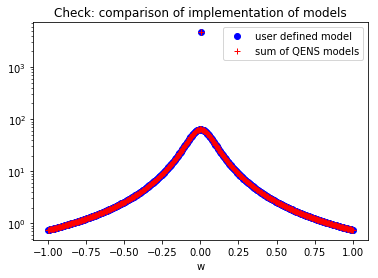

In [9]:
# Check: plot of user defined model and of the sum of related QENS models
w = np.linspace(-1,1,500)

plt.plot(w, sum_lorentz_isorot(w, scale0, centre0, hwhm0, radius0, DR0), 
         'bo', 
         label='user defined model')

plt.plot(w, QENSmodels.lorentzian(w, scale0, centre0, hwhm0) 
         + QENSmodels.sqwIsotropicRotationalDiffusion(w, Q0, scale0, centre0, radius0, DR0), 
         'r+',
        label='sum of QENS models')

plt.yscale('log')
plt.xlabel('w')
plt.title('Check: comparison of implementation of models')
plt.legend()
plt.show()

#### Resolution

In [10]:
res_func = Resolution(Workspace='res_5A', WorkspaceIndex=0)

In [11]:
# Attribute and parameters of res_func
print('Number of attributes of resolution function', res_func.nAttributes())
print('Number of parameters of resolution function', res_func.nParams())
print('Attributes of resolution function:')
print(res_func.attributeNames())

('Number of attributes of resolution function', 5)
('Number of parameters of resolution function', 0)
Attributes of resolution function:
['FileName','Workspace','WorkspaceIndex','X','Y']


#### Convolution of resolution and user defined function

In [12]:
def single_model(workspace_index):
    """ Define convolution function of resolution and user defined model
    with initial values of parameters
    To be used to create global model of all Q-values"""
    return Convolution(Resolution(Workspace='res_5A', WorkspaceIndex=workspace_index),
                       MyModel(Q=q_5A[workspace_index],
                               scale=20,
                               centre=0,
                               hwhm=0.1,
                               radius=0.98,
                               DR=2.),                  
                       FixResolution=True, 
                       NumDeriv=True)

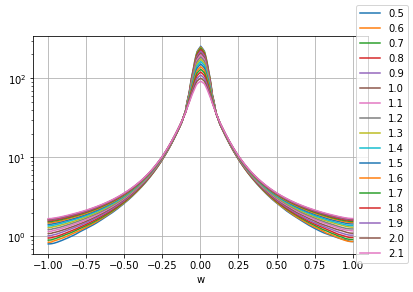

In [13]:
# Check profile, names of attributes and parameters of convolution function for all Q-values
w = np.linspace(-1, 1, 500)
for indx, Q in enumerate(q_5A):
   
    single_model_Q = single_model(indx)    
    plt.plot(w, single_model_Q(w), label='%.1f'%Q)
    
plt.yscale('log')
plt.figlegend()
plt.grid()
plt.xlabel('w')
plt.show()

#### Create global model

In [14]:
global_model = MultiDomainFunction(single_model(0), 
                                   single_model(1), 
                                   single_model(2),
                                   single_model(3), 
                                   single_model(4), 
                                   single_model(5), 
                                   single_model(6),
                                   single_model(7), 
                                   single_model(8),
                                   single_model(9), 
                                   single_model(10), 
                                   single_model(11), 
                                   single_model(12), 
                                   single_model(13), 
                                   single_model(14), 
                                   single_model(15),
                                   single_model(16), Global=['f1.DR', 'f1.radius', 'f1.hwhm'])

# Print parameters of global model
for i in range(global_model.nParams()):
        print('Name of {0}th parameter: {1}'.format(i, global_model.parameterName(i)))

Name of 0th parameter: f0.f1.scale
Name of 1th parameter: f0.f1.centre
Name of 2th parameter: f0.f1.hwhm
Name of 3th parameter: f0.f1.radius
Name of 4th parameter: f0.f1.DR
Name of 5th parameter: f1.f1.scale
Name of 6th parameter: f1.f1.centre
Name of 7th parameter: f1.f1.hwhm
Name of 8th parameter: f1.f1.radius
Name of 9th parameter: f1.f1.DR
Name of 10th parameter: f2.f1.scale
Name of 11th parameter: f2.f1.centre
Name of 12th parameter: f2.f1.hwhm
Name of 13th parameter: f2.f1.radius
Name of 14th parameter: f2.f1.DR
Name of 15th parameter: f3.f1.scale
Name of 16th parameter: f3.f1.centre
Name of 17th parameter: f3.f1.hwhm
Name of 18th parameter: f3.f1.radius
Name of 19th parameter: f3.f1.DR
Name of 20th parameter: f4.f1.scale
Name of 21th parameter: f4.f1.centre
Name of 22th parameter: f4.f1.hwhm
Name of 23th parameter: f4.f1.radius
Name of 24th parameter: f4.f1.DR
Name of 25th parameter: f5.f1.scale
Name of 26th parameter: f5.f1.centre
Name of 27th parameter: f5.f1.hwhm
Name of 28th

In [15]:
# add constraint on the parameters
# positive amplitudes
global_model.constrain("f0.f1.scale > 0.")
global_model.constrain("f1.f1.scale > 0.")
global_model.constrain("f2.f1.scale > 0.")
global_model.constrain("f3.f1.scale > 0.")
global_model.constrain("f4.f1.scale > 0.")
global_model.constrain("f5.f1.scale > 0.")
global_model.constrain("f6.f1.scale > 0.")
global_model.constrain("f7.f1.scale > 0.")
global_model.constrain("f8.f1.scale > 0.")
global_model.constrain("f9.f1.scale > 0.")
global_model.constrain("f10.f1.scale > 0.")
global_model.constrain("f11.f1.scale > 0.")
global_model.constrain("f12.f1.scale > 0.")
global_model.constrain("f13.f1.scale > 0.")
global_model.constrain("f14.f1.scale > 0.")
global_model.constrain("f15.f1.scale > 0.")
global_model.constrain("f16.f1.scale > 0.")

# positive half-width half-maximum
global_model.constrain("f0.f1.hwhm > 0.")

# positive DR
global_model.constrain("f0.f1.DR > 0.")

In [16]:
# Now relate each domain(i.e. spectrum) to each single model
domain_model = dict()
for wi in range(len(q_5A)):
    if wi == 0:
        domain_model.update({"InputWorkspace": ws_5A.name(), "WorkspaceIndex": str(wi),
            "StartX": "-1", "EndX": "1"})
    else:
        domain_model.update({"InputWorkspace_"+str(wi): ws_5A.name(), "WorkspaceIndex_"+str(wi): str(wi),
            "StartX_"+str(wi): "-1", "EndX_"+str(wi): "1"})

In [17]:
# Invoke the Fit algorithm using global_model and domain_model:
output_workspace = "glofit_"+ws_5A.name()
fit_output = Fit(Function=global_model, Output=output_workspace, CreateOutput=True, **domain_model)

In [18]:
# print some results
fitWorkspace = fit_output.OutputWorkspace
paramTable = fit_output.OutputParameters

# print results for refined parameters
print('Table of refined parameters: Name Value Error')

for i in range(paramTable.rowCount()):
    print(paramTable.column(0)[i],
          paramTable.column(1)[i],
          paramTable.column(2)[i])

Table of refined parameters: Name Value Error
('f0.f1.scale', 8.839612987017029, 0.006544898178188704)
('f0.f1.centre', -0.0007424922997110574, 0.00019253410410216397)
('f0.f1.hwhm', 0.2418731011262266, 0.0002645877924835207)
('f0.f1.radius', 2.4912821842771833, 0.0031855705832099113)
('f0.f1.DR', 0.03622714881242011, 0.0001450860632383076)
('f1.f1.scale', 9.274470524510319, 0.006470394164157864)
('f1.f1.centre', 0.0051092273429714005, 0.00017581658261983343)
('f1.f1.hwhm', 0.2418731011262266, 0.0)
('f1.f1.radius', 2.4912821842771833, 0.0)
('f1.f1.DR', 0.03622714881242011, 0.0)
('f2.f1.scale', 9.786004805629247, 0.00661881837205215)
('f2.f1.centre', 0.00554695405081959, 0.00016282244750767154)
('f2.f1.hwhm', 0.2418731011262266, 0.0)
('f2.f1.radius', 2.4912821842771833, 0.0)
('f2.f1.DR', 0.03622714881242011, 0.0)
('f3.f1.scale', 10.18067014592263, 0.006666217083553373)
('f3.f1.centre', 0.006725904598638558, 0.00015261269386971748)
('f3.f1.hwhm', 0.2418731011262266, 0.0)
('f3.f1.radius',

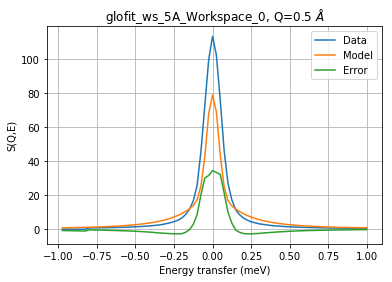

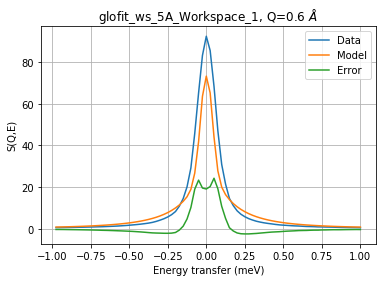

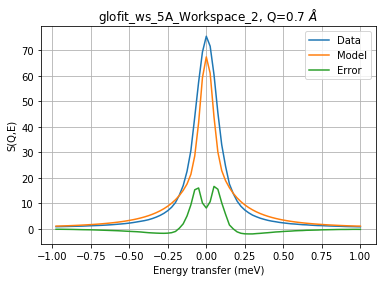

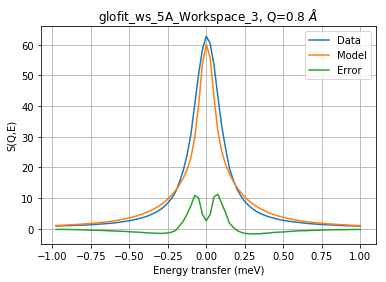

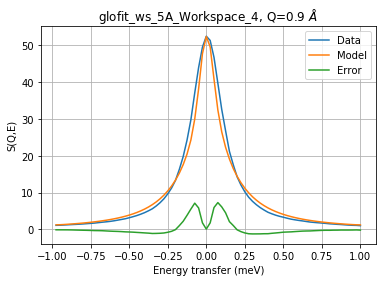

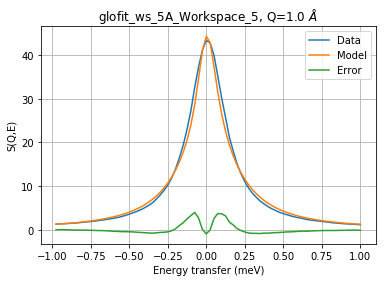

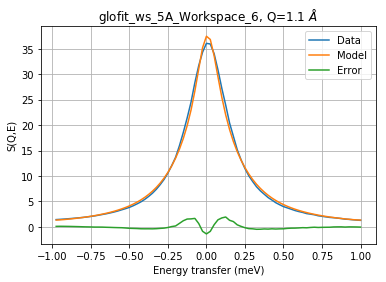

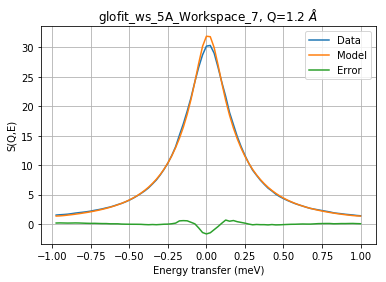

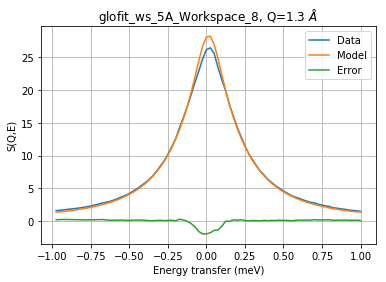

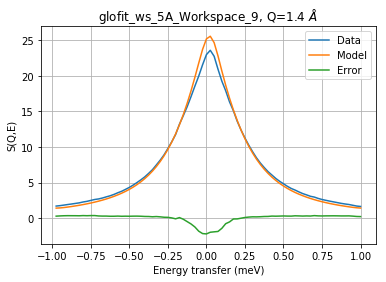

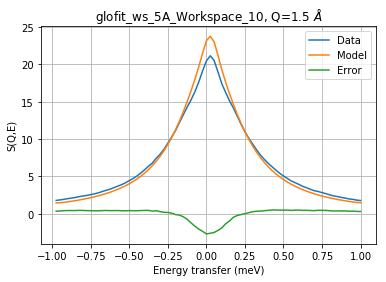

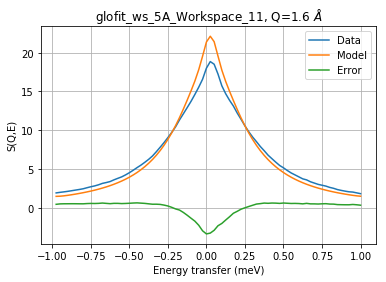

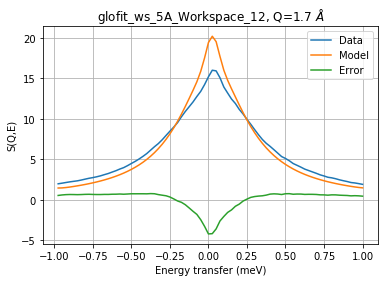

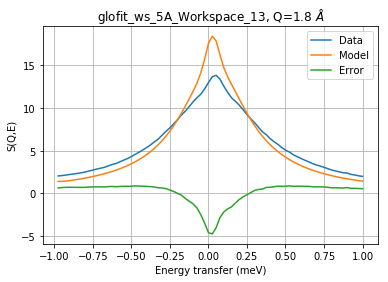

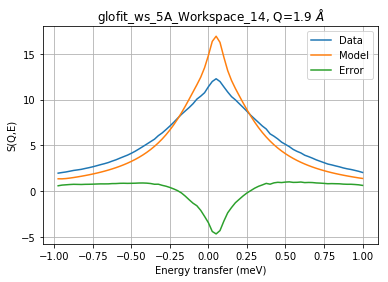

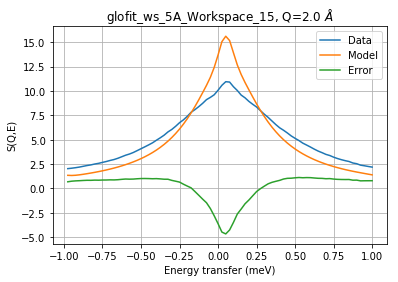

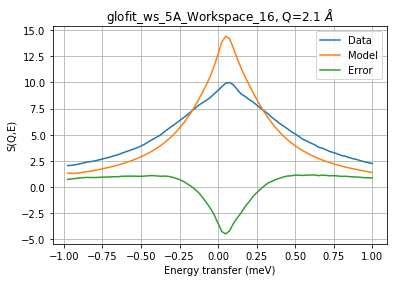

In [19]:
# Plot results: one plot / spectrum showing experimental, fitted data and difference

for indx, item in enumerate(fitWorkspace.getNames()):
    x = mtd[item].readX(0)
    plt.plot(x, mtd[item].readY(0), label="Data")
    plt.plot(x, mtd[item].readY(1), label="Model")
    plt.plot(x, mtd[item].readY(2), label="Error")
    plt.xlabel('Energy transfer (meV)')
    plt.ylabel('S(Q,E)')
    plt.legend()
    plt.grid()
    plt.title(item + r", Q={:.1f} $\AA$".format(q_5A[indx]))
    plt.show()